<a href="https://colab.research.google.com/github/Harm1995/CTA-sensitivity/blob/master/Likelihood_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The packages

In [0]:
try:
  import iminuit
  from iminuit import Minuit

except:
  !pip install iminuit

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random
import scipy
from scipy.stats import norm
import astropy
from astropy.io import fits
import seaborn as sns
import time
from tqdm.auto import tqdm, trange




time = 1

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
roi = 5                       ## Our range of interest in degrees
TeV = 10**-6                  ## Convertion rate
energy_start_bin = 3
offset = 0                    ## The offset of the telescope. We assume we look at the target directly
pre_normalisation = 1
energy_bin = 0

In [0]:
## The Energy is saved as a tuple, via this way we make it a normal list

ring_path = "/content/drive/My Drive/Colab Notebooks/master_project/rings_background/"
energy_list1 = np.array(fits.getdata(ring_path + 'ics_ring_1.fits', ext=1))
energies = []
for energy in energy_list1:
    E = float(str(energy)[1:-2])
    energies.append(E)
energies = np.array(energies)
energies = energies * TeV   


# Data

## The raw data

### Original model

In [0]:
pre_path = "/content/drive/My Drive/Colab Notebooks/master_project/"
ring_path = "/content/drive/My Drive/Colab Notebooks/master_project/rings_background/"


### Here we get the diffusive emission maps:
ics_ring_maps = []
GCE_ring_maps = []
for i in range(1,5):
  ics = np.roll(fits.getdata(ring_path + 'ics_ring_'+str(i) +'_new.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  brems = np.roll(fits.getdata(ring_path + 'bremss_ring_'+ str(i) +'_new.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  pion = np.roll(fits.getdata(ring_path + 'pion_ring_'+ str(i) +'_new.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  ics_ring_maps.append(ics)
  GCE_ring_maps.append(brems + pion)

GDE_maps = []
GDE_maps.append(ics_ring_maps)
GDE_maps.append(GCE_ring_maps)
GDE_maps = np.array(GDE_maps)

tot_ics = np.array(ics_ring_maps[0] + ics_ring_maps[1] + ics_ring_maps[2] + ics_ring_maps[3])
tot_gce = np.array(GCE_ring_maps[0] + GCE_ring_maps[1] + GCE_ring_maps[2] + GCE_ring_maps[3])


### GCE extrapolated from fermi

In [0]:
path = "/content/drive/My Drive/Colab Notebooks/data_txt_files/"

df_ics = pd.read_table(path+ 'ICS_spectra_40x40_roi_Abazajian_etal_2020.dat', skiprows=1, sep = ' '
  , header = None,  names= ['Emin', 'Emax','Ecenter',  'E^2dN/dE', 'error'])

df_gce = pd.read_table(path+ 'GasCorrelated_spectra_40x40_roi_Abazajian_etal_2020.dat', skiprows=1, sep = ' '
  , header = None,  names= ['Emin', 'Emax','Ecenter',  'E^2dN/dE', 'error'])

Fermi_eneriges_ics = df_ics['Ecenter'] /1000
Fermi_flux_ics = df_ics['E^2dN/dE']/1000
error1 = df_ics['error']/1000

Fermi_eneriges_gce = df_gce['Ecenter']/1000
Fermi_flux_gce = df_gce['E^2dN/dE']/1000
error2 = df_gce['error']/1000

def func(E, *param):
  return (param[0] * E**-param[1])

param,errors = scipy.optimize.curve_fit(func,Fermi_eneriges_gce, Fermi_flux_gce,p0 = [[10**-8,2]])
fit_func1 = [func(E,*param) for E in Fermi_eneriges_gce]
fit_func2 = [func(E,*param) for E in energies]

energy_bin = 10
GCE_ring_1_temp = GCE_ring_maps[0][energy_bin] / np.mean(tot_gce[energy_bin]) 
GCE_ring_2_temp = GCE_ring_maps[1][energy_bin] / np.mean(tot_gce[energy_bin]) 
GCE_ring_3_temp = GCE_ring_maps[2][energy_bin] / np.mean(tot_gce[energy_bin]) 
GCE_ring_4_temp = GCE_ring_maps[3][energy_bin] / np.mean(tot_gce[energy_bin]) 

new_GCE_1 = []
new_GCE_2 = []
new_GCE_3 = []
new_GCE_4 = []

param2 = [param[0], param[1] +2]
for E in energies:
  new_GCE_1.append(GCE_ring_1_temp * func(E, *param2))
  new_GCE_2.append(GCE_ring_2_temp * func(E, *param2))
  new_GCE_3.append(GCE_ring_3_temp * func(E, *param2))
  new_GCE_4.append(GCE_ring_4_temp * func(E, *param2))

new_GCE_1 = np.array(new_GCE_1)
new_GCE_2 = np.array(new_GCE_2)
new_GCE_3 = np.array(new_GCE_3)
new_GCE_4 = np.array(new_GCE_4)

tot_new_GCE = new_GCE_1 + new_GCE_2 + new_GCE_3 + new_GCE_4 

### The fermi maps

In [0]:
fermi_map = fits.getdata(pre_path + 'fig12_bubbles_template_3compSCA_40x40deg_inpaint.fits')[(40 - 2*roi):(40 + 2 * roi),(40 - 2*roi):(40 + 2 * roi)]
fermi_map = fermi_map / np.mean(fermi_map)

def fermi_function_min(E):
  phi0 = 0.5 * 10**-8
  sigma = 1.9
  E_co = 1

  fluxq = phi0 * np.exp(-E/E_co) * E**-sigma
  return fluxq

def fermi_function_max(E):
  phi0 = 1 * 10**-8
  sigma = 1.9
  E_co = 20

  fluxq = phi0 * np.exp(-E/E_co) * E**-sigma
  return fluxq


fermi_binned_min = []
fermi_binned_max = []

for E in energies:
  fermi_binned_min.append(fermi_map * fermi_function_min(E))
  fermi_binned_max.append(fermi_map * fermi_function_max(E))


fermi_binned_min = np.array(fermi_binned_min)
fermi_binned_max = np.array(fermi_binned_max)



### Alternative model

In [8]:
pre_path_alt = '/content/drive/My Drive/Colab Notebooks/master_project/Alternative_GDE/'

dust_pos =fits.getdata(pre_path_alt + 'DustPositive_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]
dust_neg =fits.getdata(pre_path_alt + 'DustNegative_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]

dust_neg = np.array(dust_neg)
dust_pos = np.array(dust_pos)



H1_maps = []
H2_maps = []
for ring in range(1,5):
  map_H2 = fits.getdata(pre_path_alt + f'H2_pohl_ring_{ring}_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]
  map_H1 = fits.getdata(pre_path_alt + f'HI_pohl_T150K_ring_{ring}_Normalized.fits')[(180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  H1_maps.append(map_H1)
  H2_maps.append(map_H2)


initial_norm_factor = (np.sum(H1_maps) + np.sum(H2_maps) + np.sum(dust_neg + dust_pos) ) / np.sum(GCE_ring_maps) 


H1_norm = []
H2_norm = []
dust_pos_norm = dust_pos / initial_norm_factor
dust_neg_norm = dust_neg / initial_norm_factor

for i in range(0,4):
  H1_norm.append(H1_maps[i] / initial_norm_factor )
  H2_norm.append(H1_maps[i] / initial_norm_factor )
import scipy

tot_alter = np.sum(H1_maps) + np.sum(H1_maps) + np.sum(dust_pos)+ np.sum(dust_neg) 
sum_gce = np.sum(tot_gce)

l2 = []
for i in range(47):
  l2.append(np.sum(tot_gce[i]))

def func(E,a,b,c):
  return (a * (E/b)**-c)

p1,p2 = scipy.optimize.curve_fit(func,energies, l2)


norm_factor = sum_gce / tot_alter

def func(E):
  b = float(0.2)
  c = float(2.5)

  return ((E/b)**-c * norm_factor *10**-3.8)



H1_1_binned = []
H1_2_binned = []
H1_3_binned = []
H1_4_binned = []

H2_1_binned = []
H2_2_binned = []
H2_3_binned = []
H2_4_binned = []

dust_binned_pos = []
dust_binned_neg = []

for E in energies:
  H1_1_binned.append(H1_maps[0] * func(E))
  H1_2_binned.append(H1_maps[1] * func(E))
  H1_3_binned.append(H1_maps[2] * func(E))
  H1_4_binned.append(H1_maps[3] * func(E))

  H2_1_binned.append(H2_maps[0] * func(E))
  H2_2_binned.append(H2_maps[1] * func(E))
  H2_3_binned.append(H2_maps[2] * func(E))
  H2_4_binned.append(H2_maps[3] * func(E))

  dust_binned_pos.append(dust_pos * func(E))
  dust_binned_neg.append(dust_neg * func(E))

tot_alt = [H1_1_binned,H1_2_binned, H1_3_binned, H1_4_binned, H2_1_binned,H2_2_binned, H2_3_binned, H2_4_binned,dust_binned_pos,dust_binned_neg]
tot_alt = np.array(tot_alt)

tot_gce_alt = np.sum(tot_alt, axis = 0)


H1_1_binned = np.array(H1_1_binned)
H1_2_binned = np.array(H1_2_binned)
H1_3_binned = np.array(H1_3_binned)
H1_4_binned = np.array(H1_4_binned)

H2_1_binned = np.array(H2_1_binned)
H2_2_binned = np.array(H2_2_binned)
H2_3_binned = np.array(H2_3_binned)
H2_4_binned = np.array(H2_4_binned)

dust_binned_pos = np.array(dust_binned_pos)
dust_binned_neg = np.array(dust_binned_neg)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in power


### Signal maps

In [0]:
path_to_signal = '/content/drive/My Drive/Colab Notebooks/data_txt_files/NB_and_F98/'
NB_ring_maps = []
F98_ring_maps = []
injections = ['inj0','inj1', 'inj2', 'inj3', 'inj4']
for inj in injections:
  temp_map = []
  temp_map2 = []
  for ring in range(1,5):
    NB_map = np.roll(fits.getdata(path_to_signal + 'NB_ring_'+ str(ring) +'_' + inj + '.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
    F98_map = np.roll(fits.getdata(path_to_signal + 'NB_ring_'+ str(ring) +'_' + inj +  '.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
    temp_map.append(NB_map)
    temp_map2.append(F98_map)
  tot1 = temp_map[0] + temp_map[1] + temp_map[2] + temp_map[3]
  tot2 = temp_map2[0] + temp_map2[1] + temp_map2[2] + temp_map2[3]
  NB_ring_maps.append(tot1)
  F98_ring_maps.append(tot2)

NB_ring_maps = np.array(NB_ring_maps)
F98_ring_maps = np.array(F98_ring_maps)

signals = [NB_ring_maps[0] + F98_ring_maps[0], NB_ring_maps[1] + F98_ring_maps[1], NB_ring_maps[2] + F98_ring_maps[2], NB_ring_maps[3] + F98_ring_maps[3],NB_ring_maps[4] + F98_ring_maps[4]]


We have the following Background flux maps

* 4 rings of ics maps 47 * 20 * 20
* 4 rings of GCE maps 47 * 20 * 20
* 1 Fermi min map 47 * 20 * 20
* 1 Fermi max map 47 * 20 * 20

An alternative GCE map extrapolated from Fermi dataL

* 4 rings of GCE maps 47 * 20 * 20


And for the alternative model:

* 4 ring maps H1 40 * 40
* 4 ring maps H2 40 * 40
* 2 dust maps 20 * 20

And the Following signal - maps:

* 5  injection spectra NB signal map 47 * 20 * 20
* 5  injection spectra F98 map 47 * 20 * 20

## Convolved data

In [0]:
files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'

orig_shape = (9, 47, 20, 20)
original_file = files_paths + 'Model_new.txt.txt'
simulated_backgrounds = np.loadtxt(original_file).reshape(orig_shape)

ics_rings = np.loadtxt(files_paths + 'ice_file.txt').reshape(4,46,20,20)
gce_rings = np.loadtxt(files_paths + 'gce_file.txt').reshape(4,46,20,20)
gce2_rings = np.loadtxt(files_paths + 'gce2_file.txt').reshape(4,46,20,20)
NB_rings = np.loadtxt(files_paths + 'NB_file.txt').reshape(5,46,20,20)
F98_rings = np.loadtxt(files_paths + 'F98_file.txt').reshape(5,46,20,20)
alternative_gce = np.loadtxt(files_paths + 'Alternative_gce.txt').reshape(10,46,20,20)
fermi_maps = np.loadtxt(files_paths + 'fermi_map').reshape(2,46,20,20)
fermi_bubble = simulated_backgrounds[-1][:-1] * 137


signal_inj_list = NB_rings + F98_rings
all_backgrounds = np.array([ics_rings[0], ics_rings[1], ics_rings[2], ics_rings[3], gce_rings[0], gce_rings[1], gce_rings[2], gce_rings[3],fermi_bubble])


We have the following Background Count maps

* 4 rings of ics maps 46 * 20 * 20
* 4 rings of GCE maps 46 * 20 * 20
* 2 Fermi maps 46 * 20 * 20


And for the alternative model:


* 4 ring maps H1 46 * 40 * 40
* 4 ring maps H2 46 * 40 * 40
* 4 rings of ics 46 * 20 * 20
* 2 dust maps 46 * 20 * 20
* 2 Fermi maps 46 * 20 * 20

And the Following signal - maps:

* 5  injection spectra NB signal map 46 * 20 * 20
* 5  injection spectra F98 map 46 * 20 * 20

## Compressing again to 11 rings

In [0]:
Ics_ring_1_template = []
Ics_ring_2_template = []
Ics_ring_3_template = []
Ics_ring_4_template = []
GCE_ring_1_template = []
GCE_ring_2_template = []
GCE_ring_3_template = []
GCE_ring_4_template = []

fermi_template = []

NB_0_template = []
NB_1_template = []
NB_2_template = []
NB_3_template = []
NB_4_template = []

F98_0_template = []
F98_1_template = []
F98_2_template = []
F98_3_template = []
F98_4_template = []

H1_ring_1_template = []
H1_ring_2_template = []
H1_ring_3_template = []
H1_ring_4_template = []

H2_ring_1_template = []
H2_ring_2_template = []
H2_ring_3_template = []
H2_ring_4_template = []

dust_pos_template = []
dust_neg_template = []


new_energies = []

for j in range(0,11):
  i = 2+j*4
  new_energies.append(energies[i])


  Ics_ring_1_template.append(np.sum(ics_rings[0][i:i+4], axis = 0))
  Ics_ring_2_template.append(np.sum(ics_rings[1][i:i+4], axis = 0))
  Ics_ring_3_template.append(np.sum(ics_rings[2][i:i+4], axis = 0))
  Ics_ring_4_template.append(np.sum(ics_rings[3][i:i+4], axis = 0))

  GCE_ring_1_template.append(np.sum(gce_rings[0][i:i+4], axis = 0))
  GCE_ring_2_template.append(np.sum(gce_rings[1][i:i+4], axis = 0))
  GCE_ring_3_template.append(np.sum(gce_rings[2][i:i+4], axis = 0))
  GCE_ring_4_template.append(np.sum(gce_rings[3][i:i+4], axis = 0))

  fermi_template.append(np.sum(fermi_maps[0][i:i+4], axis = 0))

  NB_0_template.append(np.sum(NB_rings[0][i:i+4], axis = 0))
  NB_1_template.append(np.sum(NB_rings[1][i:i+4], axis = 0))
  NB_2_template.append(np.sum(NB_rings[2][i:i+4], axis = 0))
  NB_3_template.append(np.sum(NB_rings[3][i:i+4], axis = 0))
  NB_4_template.append(np.sum(NB_rings[4][i:i+4], axis = 0))

  F98_0_template.append(np.sum(F98_rings[0][i:i+4], axis = 0))
  F98_1_template.append(np.sum(F98_rings[1][i:i+4], axis = 0))
  F98_2_template.append(np.sum(F98_rings[2][i:i+4], axis = 0))
  F98_3_template.append(np.sum(F98_rings[3][i:i+4], axis = 0))
  F98_4_template.append(np.sum(F98_rings[4][i:i+4], axis = 0))

  H1_ring_1_template.append(np.sum(alternative_gce[0][i:i+4], axis = 0))
  H1_ring_2_template.append(np.sum(alternative_gce[1][i:i+4], axis = 0))
  H1_ring_3_template.append(np.sum(alternative_gce[2][i:i+4], axis = 0))
  H1_ring_4_template.append(np.sum(alternative_gce[3][i:i+4], axis = 0))

  H2_ring_1_template.append(np.sum(alternative_gce[4][i:i+4], axis = 0))
  H2_ring_2_template.append(np.sum(alternative_gce[5][i:i+4], axis = 0))
  H2_ring_3_template.append(np.sum(alternative_gce[6][i:i+4], axis = 0))
  H2_ring_4_template.append(np.sum(alternative_gce[7][i:i+4], axis = 0))

  dust_pos_template.append(np.sum(alternative_gce[8][i:i+4], axis = 0))
  dust_neg_template.append(np.sum(alternative_gce[9][i:i+4], axis = 0))



Ics_ring_1_template = np.array(Ics_ring_1_template)
Ics_ring_2_template = np.array(Ics_ring_2_template)
Ics_ring_3_template = np.array(Ics_ring_3_template)
Ics_ring_4_template = np.array(Ics_ring_4_template)
GCE_ring_1_template = np.array(GCE_ring_1_template)
GCE_ring_2_template = np.array(GCE_ring_2_template)
GCE_ring_3_template = np.array(GCE_ring_3_template)
GCE_ring_4_template = np.array(GCE_ring_4_template)

fermi_template = np.array(fermi_template)

NB_0_template = np.array(NB_0_template)
NB_1_template = np.array(NB_1_template)
NB_2_template = np.array(NB_2_template)
NB_3_template = np.array(NB_3_template)
NB_4_template = np.array(NB_4_template)

NB_templates = np.array([NB_0_template, NB_1_template, NB_2_template, NB_3_template, NB_4_template])


F98_0_template = np.array(F98_0_template)
F98_1_template = np.array(F98_1_template)
F98_2_template = np.array(F98_2_template)
F98_3_template = np.array(F98_3_template)
F98_4_template = np.array(F98_4_template)

F98_templates = np.array([F98_0_template, F98_1_template, F98_2_template, F98_3_template, F98_4_template])

H1_ring_1_template = np.array(H1_ring_1_template)
H1_ring_2_template = np.array(H1_ring_2_template)
H1_ring_3_template = np.array(H1_ring_3_template)
H1_ring_4_template = np.array(H1_ring_4_template)

H2_ring_1_template = np.array(H2_ring_1_template)
H2_ring_2_template = np.array(H2_ring_2_template)
H2_ring_3_template = np.array(H2_ring_3_template)
H2_ring_4_template = np.array(H2_ring_4_template)

dust_pos_template = np.array(dust_pos_template)
dust_neg_template = np.array(dust_neg_template)


# Plotting the data

## The count maps

### Model 1

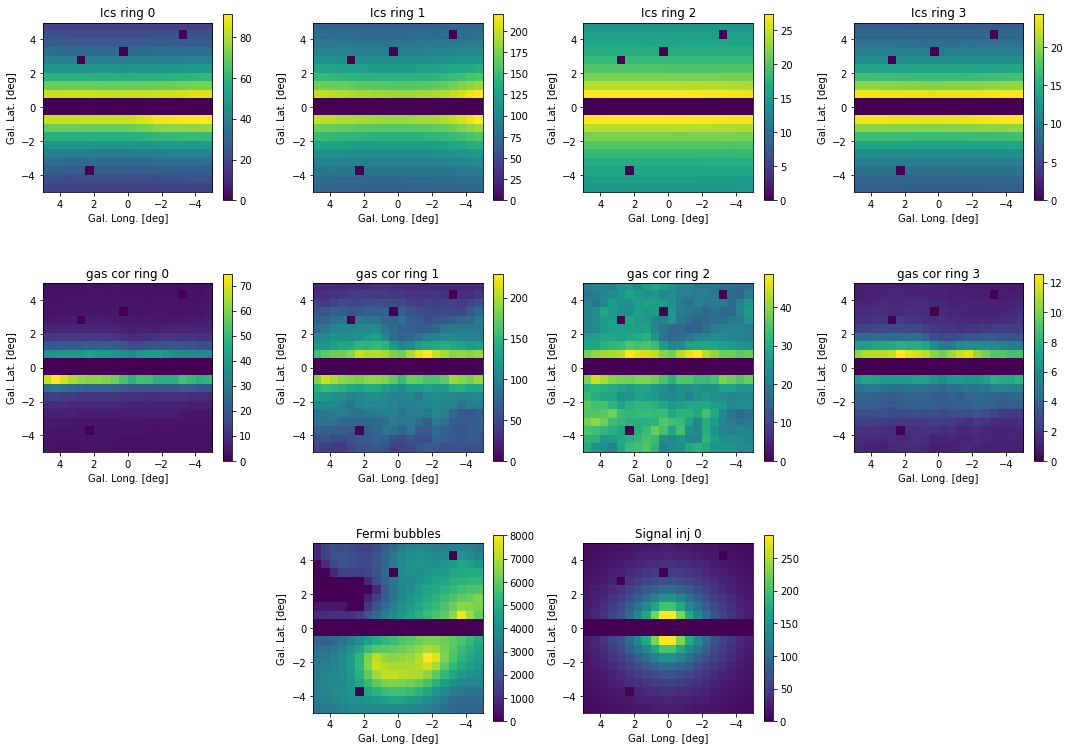

In [12]:
energy_bin = 15
shrink = 0.8
fig,ax = plt.subplots(3,4, figsize = (15,11))

sns.reset_defaults()

for i in range(4):
  plot = ax[0][i].imshow(ics_rings[i][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[0][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]", title = f'Ics ring {i}')
  fig.colorbar(plot, ax = ax[0][i], shrink = shrink)

for i in range(4):
  plot = ax[1][i].imshow(gce_rings[i][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[1][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'gas cor ring {i}')
  fig.colorbar(plot, ax = ax[1][i], shrink = shrink)

plot = ax[2][1].imshow(fermi_maps[1][energy_bin], extent = [roi,-roi,-roi,roi])
ax[2][1].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Fermi bubbles')
fig.colorbar(plot, ax = ax[2][1], shrink = shrink)

plot = ax[2][2].imshow(NB_rings[0][energy_bin], extent = [roi,-roi,-roi,roi])
ax[2][2].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Signal inj 0')
fig.colorbar(plot, ax = ax[2][2], shrink = shrink)


fig.delaxes(ax[2][0])
fig.delaxes(ax[2][3])

fig.tight_layout()
plt.show()

### Model 2

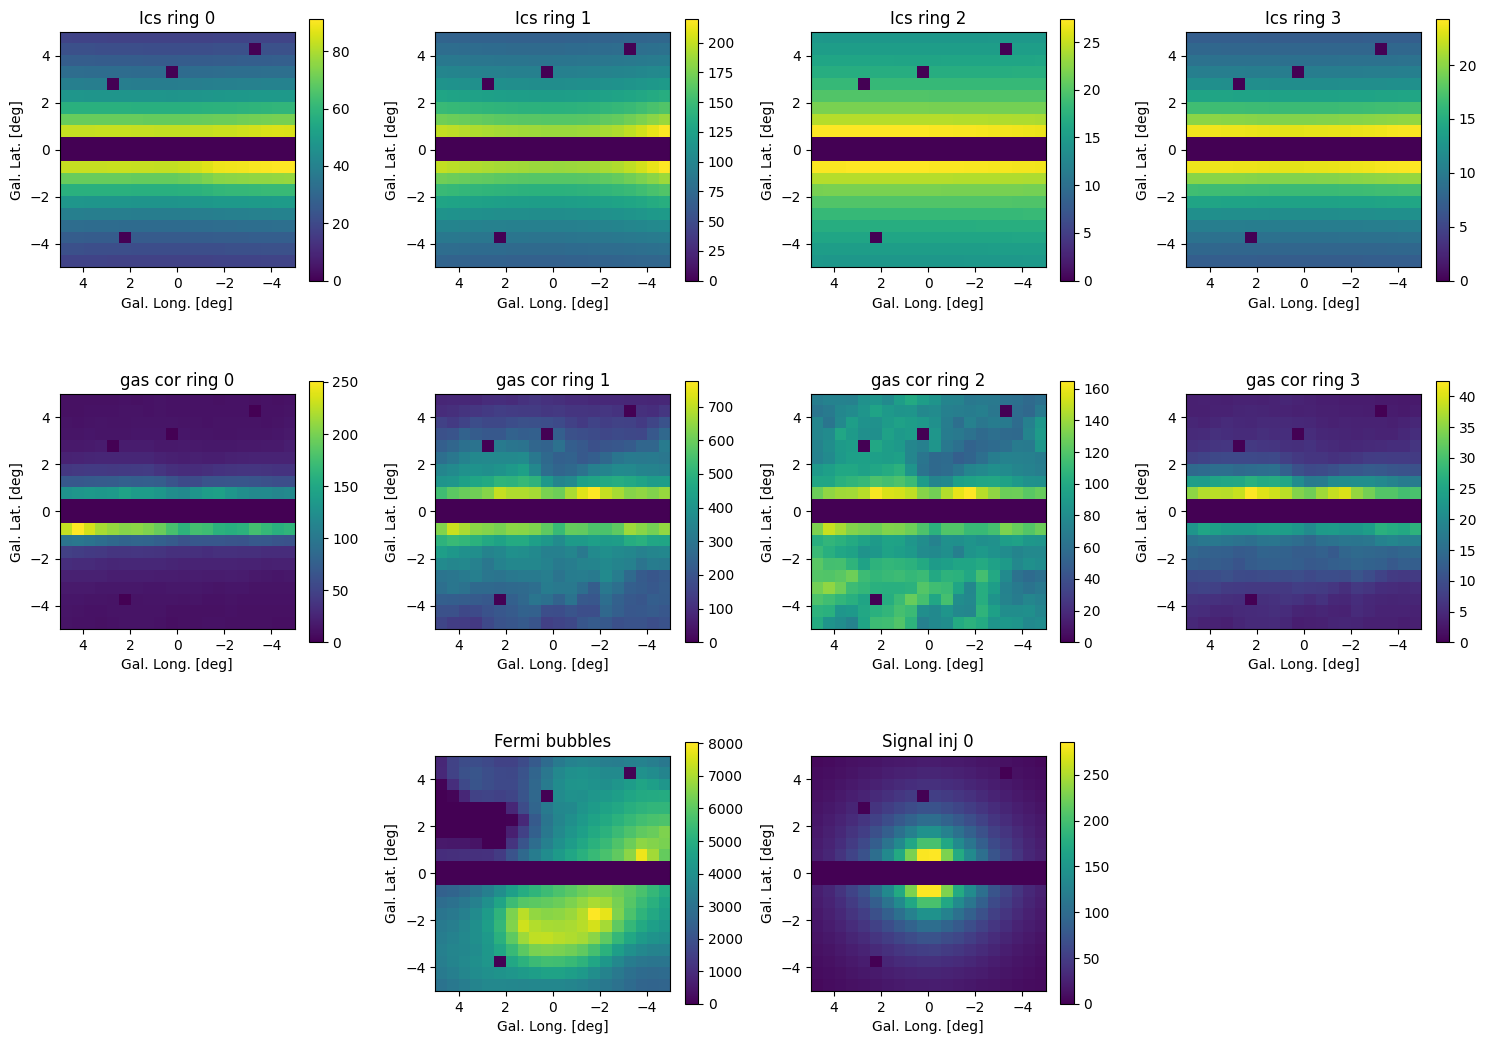

In [13]:
energy_bin = 15
shrink = 0.8
fig,ax = plt.subplots(3,4, figsize = (15,11))


for i in range(4):
  plot = ax[0][i].imshow(ics_rings[i][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[0][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]", title = f'Ics ring {i}')
  fig.colorbar(plot, ax = ax[0][i], shrink = shrink)

for i in range(4):
  plot = ax[1][i].imshow(gce2_rings[i][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[1][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'gas cor ring {i}')
  fig.colorbar(plot, ax = ax[1][i], shrink = shrink)

plot = ax[2][1].imshow(fermi_maps[1][energy_bin], extent = [roi,-roi,-roi,roi])
ax[2][1].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Fermi bubbles')
fig.colorbar(plot, ax = ax[2][1], shrink = shrink)

plot = ax[2][2].imshow(NB_rings[0][energy_bin], extent = [roi,-roi,-roi,roi])
ax[2][2].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Signal inj 0')
fig.colorbar(plot, ax = ax[2][2], shrink = shrink)


fig.delaxes(ax[2][0])
fig.delaxes(ax[2][3])

fig.tight_layout()
plt.show()

### Model 3

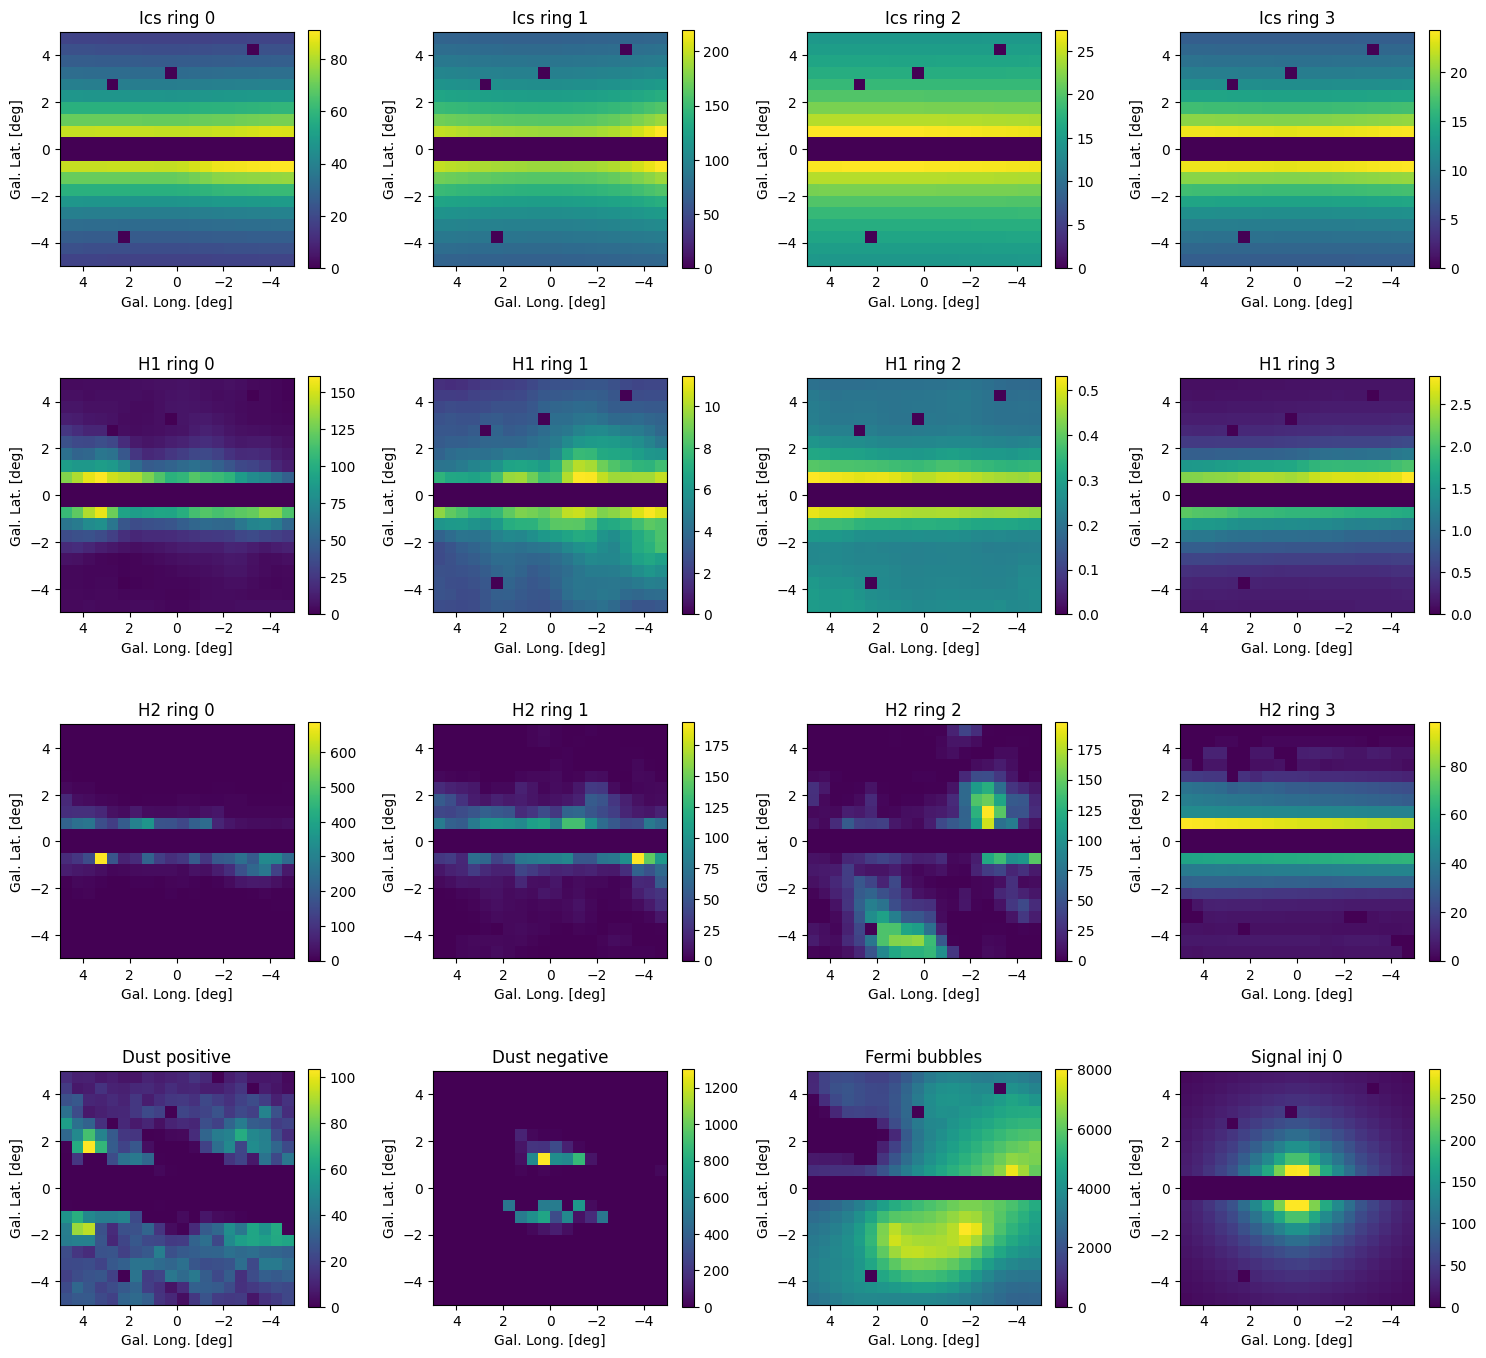

In [14]:
energy_bin = 15
shrink = 0.8
fig,ax = plt.subplots(4,4, figsize = (15,14))


for i in range(4):
  plot = ax[0][i].imshow(ics_rings[i][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[0][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]", title = f'Ics ring {i}')
  fig.colorbar(plot, ax = ax[0][i], shrink = shrink)

for i in range(4):
  plot = ax[1][i].imshow(alternative_gce[i][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[1][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'H1 ring {i}')
  fig.colorbar(plot, ax = ax[1][i], shrink = shrink)

for i in range(4):
  j = i+4
  plot = ax[2][i].imshow(alternative_gce[j][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[2][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'H2 ring {i}')
  fig.colorbar(plot, ax = ax[2][i], shrink = shrink)


plot = ax[3][0].imshow(alternative_gce[8][energy_bin], extent = [roi,-roi,-roi,roi])
ax[3][0].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Dust positive')
fig.colorbar(plot, ax = ax[3][0], shrink = shrink)

plot = ax[3][1].imshow(alternative_gce[9][energy_bin], extent = [roi,-roi,-roi,roi])
ax[3][1].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Dust negative')
fig.colorbar(plot, ax = ax[3][1], shrink = shrink)


plot = ax[3][2].imshow(fermi_maps[1][energy_bin] , extent = [roi,-roi,-roi,roi])
ax[3][2].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Fermi bubbles')
fig.colorbar(plot, ax = ax[3][2], shrink = shrink)

plot = ax[3][3].imshow(NB_rings[0][energy_bin], extent = [roi,-roi,-roi,roi])
ax[3][3].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Signal inj 0')
fig.colorbar(plot, ax = ax[3][3], shrink = shrink)


fig.tight_layout()
plt.show()

## The spectral shape

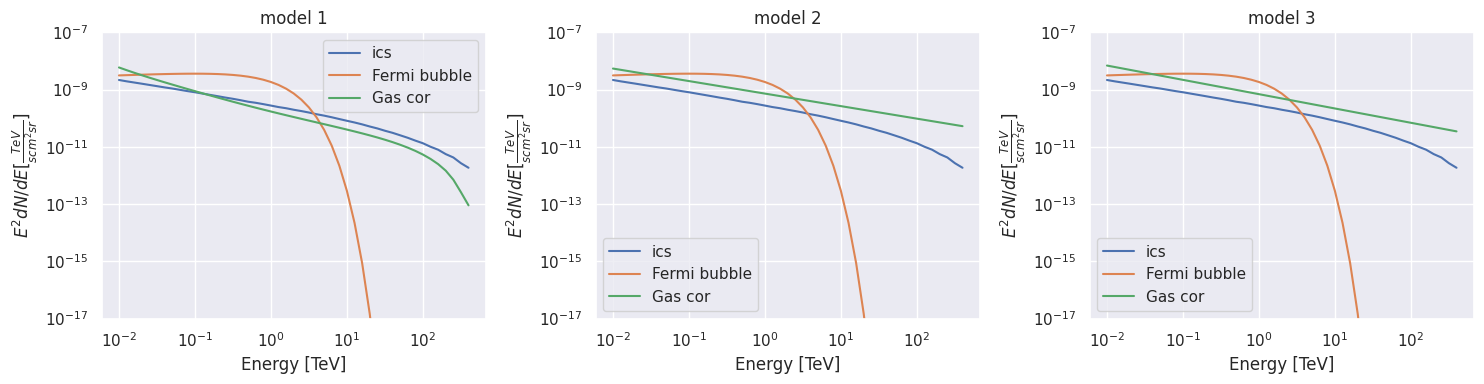

In [15]:
ics_spectrum = [np.mean(tot_ics[i])*energies[i]**2 *10**6 for i in range(47)]
fermi_spectrum = [np.mean(fermi_binned_min[i]) * energies[i]**2 for i in range(47) ]

ics_gce1 = [np.mean(tot_gce[i])*energies[i]**2 *10**6 for i in range(47)]
ics_gce2 = [np.mean(tot_new_GCE[i])*energies[i]**2 for i in range(47)]
ics_gce3 = [np.mean(tot_gce_alt[i])*energies[i]**2*10**6 for i in range(47)]

sns.set()

fig, ax = plt.subplots(1,3, figsize = (15,4))

for i in range(3):
  ax[i].plot(energies, ics_spectrum, label = 'ics')
  ax[i].plot(energies, fermi_spectrum, label = 'Fermi bubble')
  ax[i].set(yscale= 'log', xscale= 'log',ylabel = r'$E^{2}dN/dE [\frac{TeV}{s cm^{2} sr}]$', xlabel = r'Energy [TeV]', title = f"model {i + 1}")
  ax[i].set_ylim(10**-17,10**-7)

ax[0].plot(energies, ics_gce1, label = 'Gas cor')
ax[1].plot(energies, ics_gce2, label = 'Gas cor')
ax[2].plot(energies, ics_gce3, label = 'Gas cor')

for i in range(3):
  ax[i].legend()


fig.tight_layout()

plt.show()



# Creating the synthetic data

### The parameters we use

In [0]:
MC_times = 15
ss_steps = 5
signal_strengts = np.logspace(-2,0 ,ss_steps)
injection_spectra = 0
sigma = 0.3

### the sythentic data

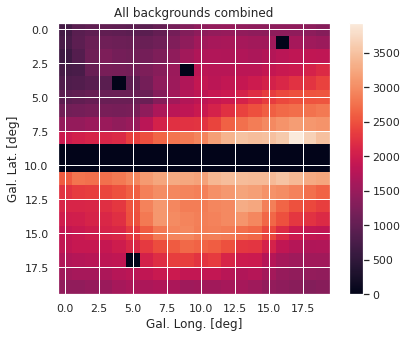

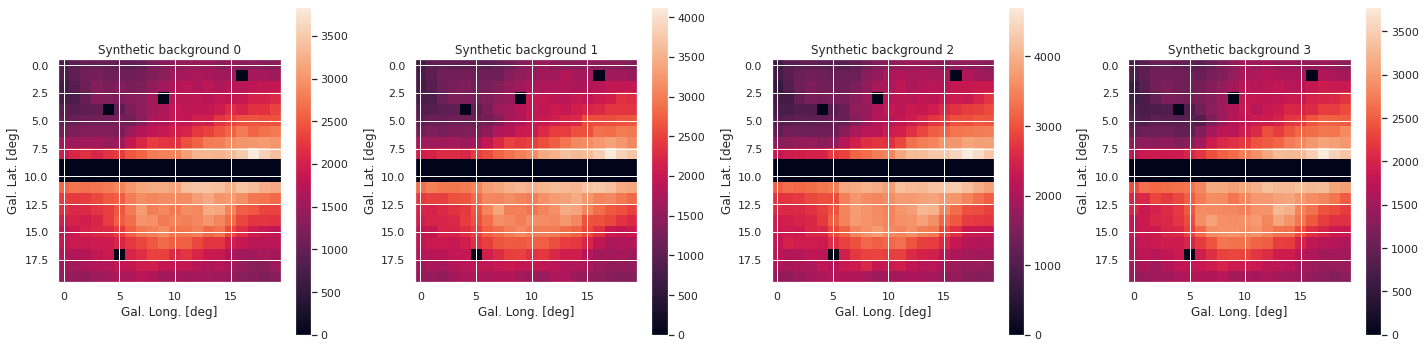

(5, 15, 11, 20, 20)

In [37]:
all_backgrounds = [Ics_ring_1_template, Ics_ring_2_template, Ics_ring_3_template, Ics_ring_4_template,
                GCE_ring_1_template, GCE_ring_2_template, GCE_ring_3_template, GCE_ring_4_template, fermi_template]
signal_conv = NB_templates[injection_spectra]
all_backgrounds = np.array(all_backgrounds)



def random_counts_with_signal(signal_strength,sigma, all_backgrounds, signal_conv):
  count_matrix = np.zeros(signal_conv.shape)
  for mapn in all_backgrounds:
    after_norm = np.random.normal(1, sigma) * mapn
    after_norm = after_norm.clip(0)
    count_matrix += after_norm
  signal_norm = signal_conv * signal_strength
  count_matrix += signal_norm

  count_matrix = np.random.poisson(count_matrix)

  return count_matrix

all_simulated_background = []
for ss in signal_strengts:
  list_MC = []
  for _ in range(MC_times):
    a = random_counts_with_signal(ss,sigma, all_backgrounds, signal_conv)
    list_MC.append(a)
  all_simulated_background.append(list_MC)



all_simulated_background = np.array(all_simulated_background)
sns.set()

## PLotting an example
fig,ax = plt.subplots(figsize = (7,5))
a = ax.imshow(np.sum(all_backgrounds, axis = 0)[0])
ax.set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'All backgrounds combined')
fig.colorbar(a, ax = ax)
plt.show()

fig,ax = plt.subplots(1,4,figsize = (20,5))

for i in range(4):
  a = ax[i].imshow(all_simulated_background[0][i][0])
  ax[i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Synthetic background {i}')
  fig.colorbar(a, ax = ax[i])

fig.tight_layout()

plt.show()

all_simulated_background.shape


#The bin by bin analysis class

In [0]:
class analysis:

  def __init__(self, signal_strength, model_backgrounds,signal1,data_map):
    self.signal_strength = signal_strength
    self.counts_m = data_map
    self.all_backgrounds = model_backgrounds
    self.signal_conv = signal1
    self.signal1 = signal1
    self.sigma = sigma
    self.energy_bin =  energy_bin


  def L0_model_long(self, params, i,j):
    """
    The background only model
    """

    tot_back = 0
    for a in range(len(self.all_backgrounds)):
      tot_back += params[a] * self.all_backgrounds[a][i][j]
    return tot_back

  def L1_model_long(self, params, i,j):
    """
    The background plus signal model
    """

    tot_back = 0
    for a in range(len(self.all_backgrounds)):
      tot_back += params[a] * self.all_backgrounds[a][i][j]  
    
    tot_back += params[-1] * self.signal1[i][j]
    
    return tot_back


  
  def lik0(self,params):
    """
    Function that computes the likelihood for a given set of parameters  of the background only model
    """
    p_sum = 0
    for i,j in np.ndindex(self.signal_conv.shape):
      counts = self.counts_m[i][j]
      counts_model = self.L0_model_long(params, i,j)
      if counts_model > 0:  
        p = counts * np.log(counts_model) - counts_model
        p_sum += p
    return -p_sum



  def lik1(self,params):
    """
    Function that computes the likelihood for a given set of parameters of the background + signal model
    """
    p_sum = 0
    for i,j in np.ndindex(self.signal_conv.shape):
      counts = self.counts_m[i][j]
      counts_model = self.L1_model_long(params, i,j)
      if counts_model > 0:  
        p = counts * np.log(counts_model) - counts_model
        p_sum += p
    return -p_sum


  
  def Test_stat(self):
    init_gues0 = [1 for __ in range(len(self.all_backgrounds))]
    init_gues1 = [1 for __ in range(len(self.all_backgrounds))]
    range0 = (0, 10)
    range1 = (0, 10)
    limit_list1 = [range0 for __ in range(len(self.all_backgrounds))]
    limit_list2 = [range1 for __ in range(len(self.all_backgrounds))]
    limit_list2.append((0, None))
    init_gues1.append(self.signal_strength)
    m_0 = Minuit.from_array_func(self.lik0, init_gues0, error = 0.1, limit= limit_list1, errordef=0.5)
    m_1 = Minuit.from_array_func(self.lik1, init_gues1, error = 0.1, limit= limit_list2, errordef=0.5)
    c = m_0.migrad() 
    d = m_1.migrad()
    a = -m_0.fval 
    b = -m_1.fval
    T = -2*(a-b)
    return T, c,d,m_0,m_1


# Doing the analysis

In [0]:
all_T = []
all_T_std = []
all_f = []
all_f_Std = []


for k in range(0,11):     ## We do the analysis for all 11 energy bins

  fit_values = []
  T_values = []
  energy_bin = k
  print (f"at energy bin {k}:")
  for signal_bin in tqdm(range(ss_steps)):    ### For every injected signal strength
    ss = signal_strengts[signal_bin]
    local_fit_values = []
    local_T_values = []

    for MC in range(MC_times):                 ### Monte carlo analysis


      model_backgrounds = np.array([Ics_ring_1_template[energy_bin], Ics_ring_2_template[energy_bin],  Ics_ring_3_template[energy_bin], Ics_ring_4_template[energy_bin],
                      GCE_ring_1_template[energy_bin], GCE_ring_2_template[energy_bin], GCE_ring_3_template[energy_bin], GCE_ring_4_template[energy_bin], fermi_template[energy_bin]])

      signal1 = NB_templates[injection_spectra][energy_bin]
      data_map = all_simulated_background[signal_bin][MC][energy_bin]

      M = analysis(ss, model_backgrounds,signal1,data_map)
      T, c,d,m_0,m_1 = M.Test_stat()
      a = [m_1.values[x] for x in range(len(m_1.values))]

      local_fit_values.append(a)
      local_T_values.append(T)

    fit_values.append(local_fit_values)
    T_values.append(local_T_values)




  fit_values = np.array(fit_values)
  T_values = np.array(T_values)

  a = np.mean(fit_values, axis = 1)
  b = np.std(fit_values, axis = 1)
  c = np.mean(T_values, axis = 1)
  d = np.std(T_values, axis = 1)  

  all_T.append(c)
  all_T_std.append(d)
  all_f.append(a)
  all_f_Std.append(b)

all_T = np.array(all_T)
all_f = np.array(all_f)
all_T_std = np.array(all_T_std)
all_f_Std = np.array(all_f_Std)


at energy bin 0:



at energy bin 1:


## Putting it in txt files

In [0]:
files_paths = '/content/drive/My Drive/Colab Notebooks/Fits_values/'
file1 = open(files_paths + f'all_T_inj_{injection_spectra}', "w")
file2 = open(files_paths + f'all_f_inj_{injection_spectra}', "w")

file3 = open(files_paths + f'all_T_inj_{injection_spectra}_std', "w")
file4 = open(files_paths + f'all_f_inj_{injection_spectra}_std', "w")

for i in np.ndindex(all_T.shape):
  np.savetxt(file1, [all_T[i]])

for i in np.ndindex(all_f.shape):
  np.savetxt(file2, [all_f[i]])

for i in np.ndindex(all_T_std.shape):
  np.savetxt(file3, [all_T_std[i]])

for i in np.ndindex(all_f.shape):
  np.savetxt(file4, [all_f_Std[i]])


file1.close()
file2.close()  
file3.close()
file4.close()  

## Plotting it

In [0]:
files_paths = '/content/drive/My Drive/Colab Notebooks/Fits_values/'
all_T = np.loadtxt(files_paths + f'all_T_inj_{injection_spectra}').reshape(11,ss_steps)
all_f = np.loadtxt(files_paths + f'all_f_inj_{injection_spectra}').reshape(11,10,ss_steps)
all_T_std = np.loadtxt(files_paths + f'all_T_inj_{injection_spectra}_std').reshape(11,ss_steps)
all_f_Std = np.loadtxt(files_paths + f'all_f_inj_{injection_spectra}_std').reshape(11,10,ss_steps)

The plot for MC = 15 and injection spectra 0


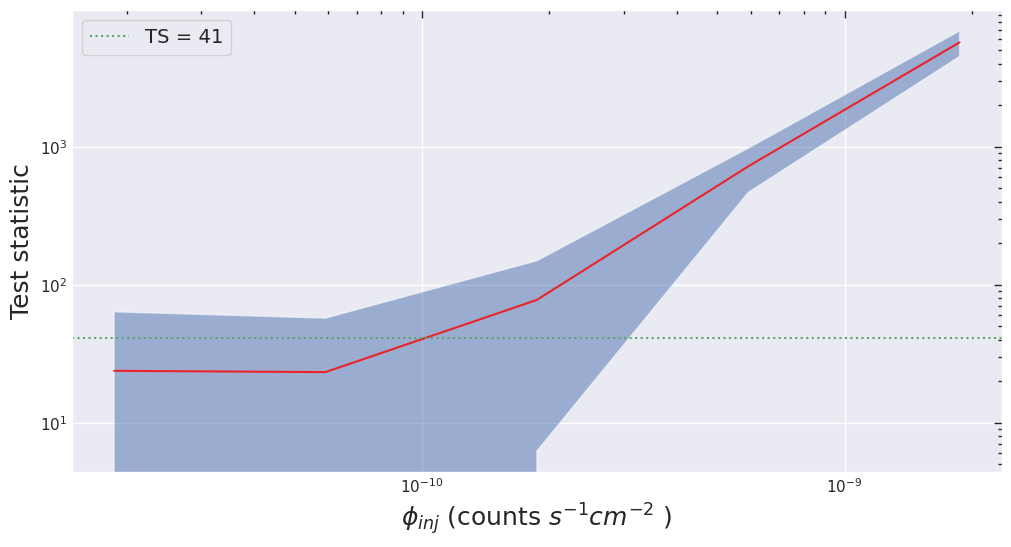

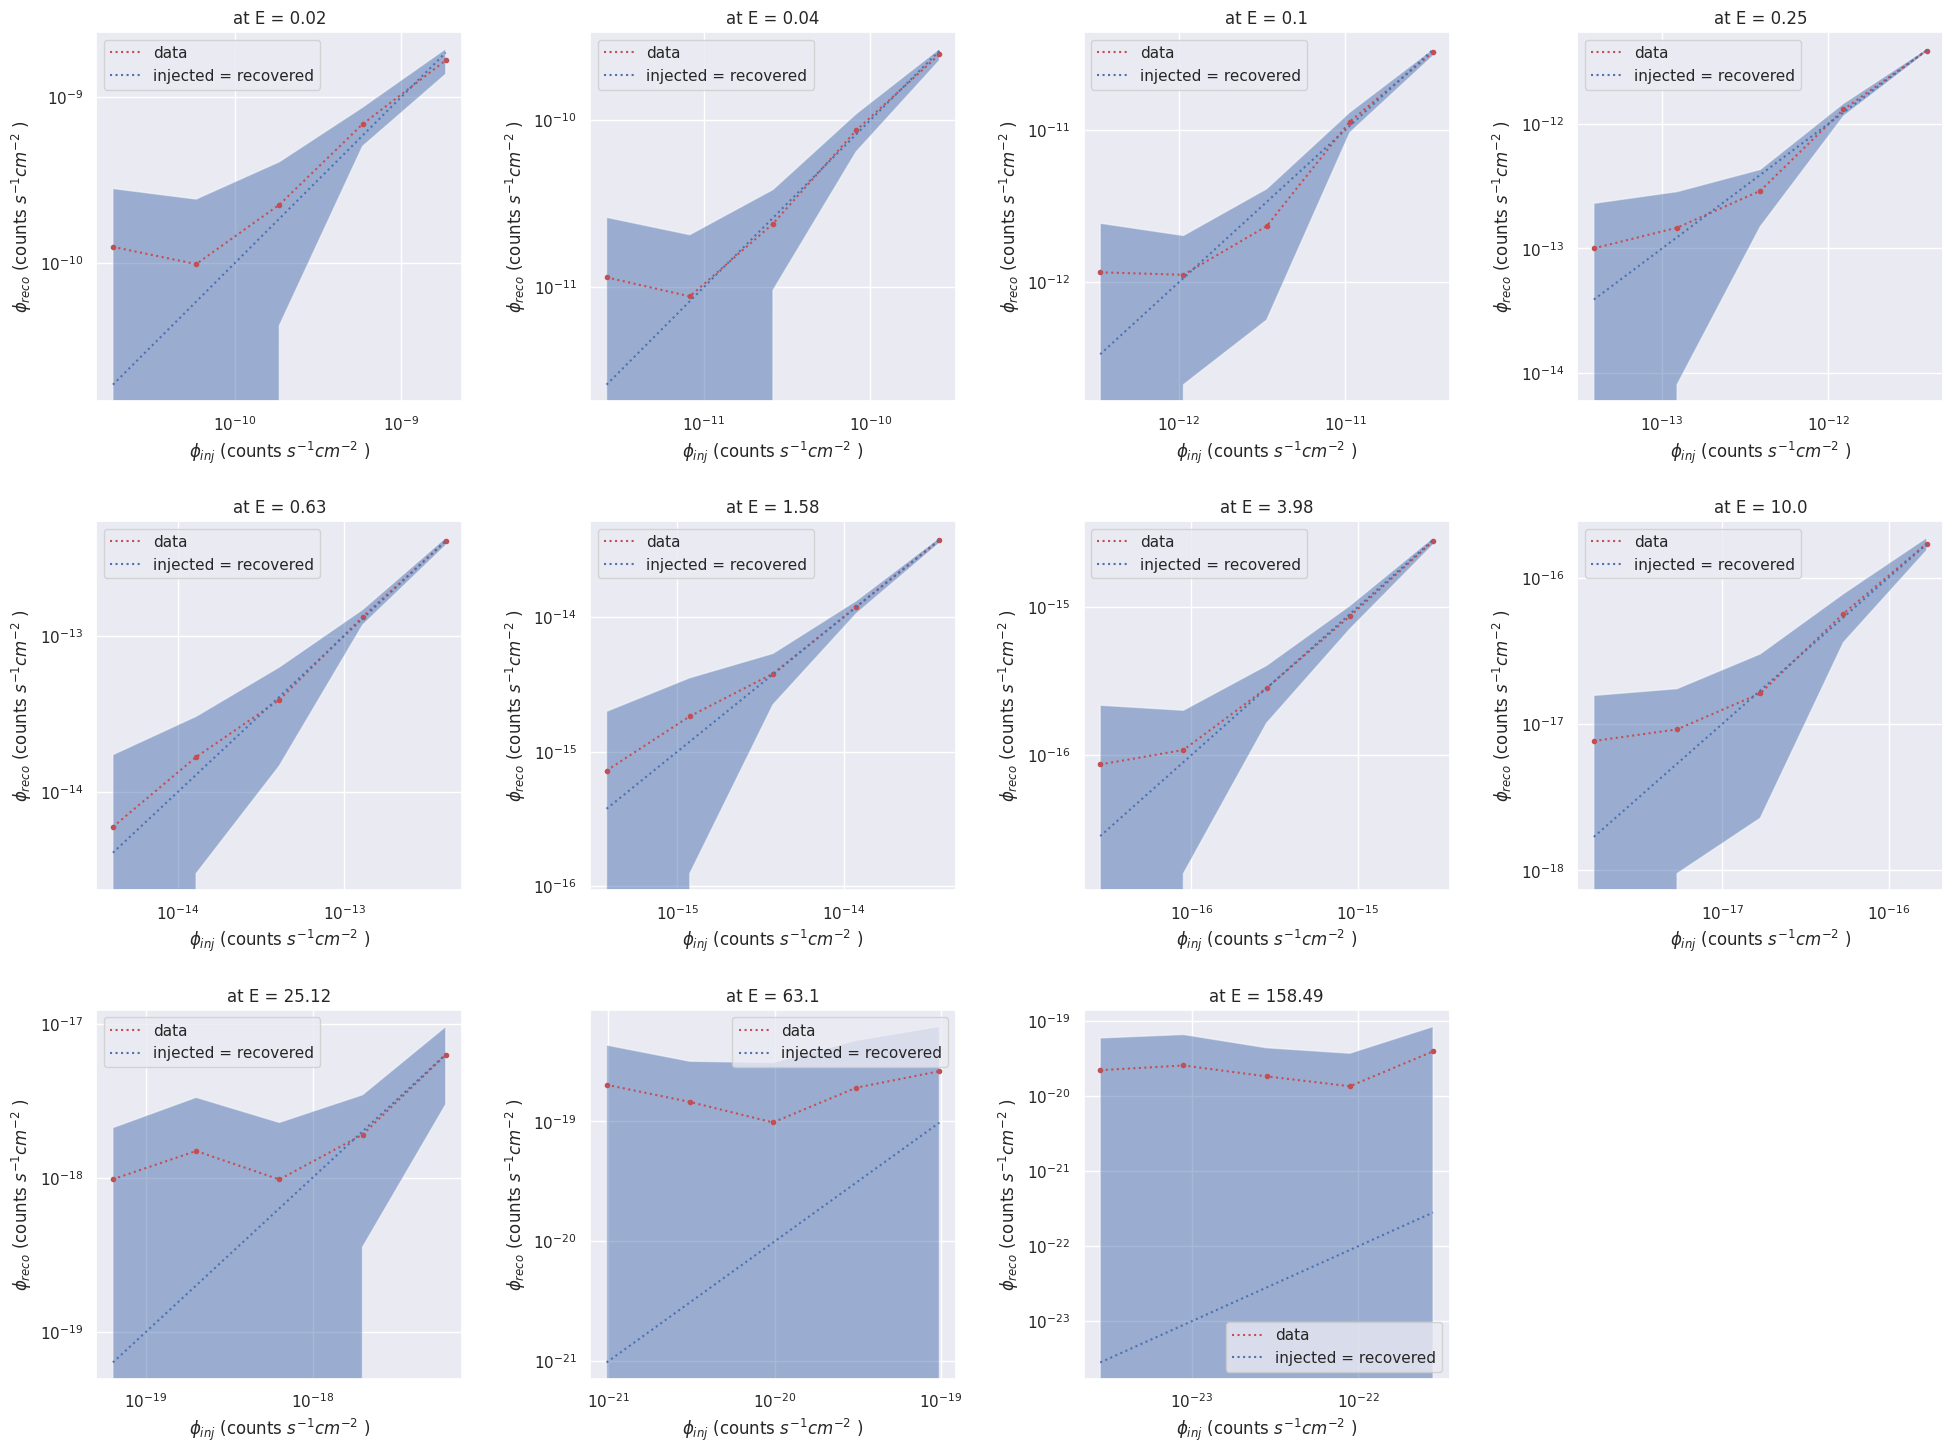

In [20]:
all_f = np.array(all_f)
all_T = np.array(all_T)


total_T = np.sum(all_T, axis = 0)
error_T = np.sum(all_T_std, axis = 0)

signal_signal_per_new_bin = []
range_oi = 100 * (np.pi/180)**2



for i in range(46):
  signal_signal_per_new_bin.append(np.mean(signals[injection_spectra][i])*(energies[i+1] - energies[i]) * 10**6 * range_oi)

signal = np.sum(signal_signal_per_new_bin)
signal_per_new_bin = [np.sum(signal_signal_per_new_bin[2 + 4*i:4*i+6]) for i in range(11)]


import matplotlib as mpl
mpl.rcParams['font.size'] = 17.0
#mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 18.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.figsize'] = (7, 5)
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1
#plt.style.use('classic')
#rc('font', **{'size'   : 22})
#plt.yscale('symlog', linthreshy=1.00e-02)


print (f"The plot for MC = {MC_times} and injection spectra {injection_spectra}")

plt.figure(figsize= (12,6))
plt.plot(signal_strengts * signal, total_T, color = 'red', alpha = 0.8)
plt.fill_between(signal_strengts * signal, total_T-error_T, total_T+error_T, alpha = 0.5)
plt.xscale('log')
plt.yscale('log')
plt.axhline(41, linestyle = ':', color = 'g', label = "TS = 41")
plt.xlabel(r'$\phi_{inj}$ (counts $s^{-1} cm^{-2}$ )')
plt.ylabel('Test statistic')
plt.legend()
plt.show()

extracted = []
error = []
for i in all_f:
  a = [x[-1] for x in i]
  extracted.append(a)

for i in all_f_Std:
  a = [x[-1] for x in i]
  error.append(a)

extracted = np.array(extracted)
error = np.array(error)

a = signals[injection_spectra]
signal_per_new_bin = []
for i in range(11):
  j = 2+4*i
  signal_per_new_bin.append(np.sum(a[j]) + np.sum(a[j+1]) + np.sum(a[j+2])+ np.sum(a[j+3]))

sns.set()
fig, ax = plt.subplots(3,4 , figsize=(20,15))

for i in range(0,11):
  plot = ax[int(i/4)][i%4]
  plot.plot(signal_strengts * signal_per_new_bin[i] , extracted[i] * signal_per_new_bin[i], '.',color = "r")
  plot.plot(signal_strengts * signal_per_new_bin[i] , extracted[i] * signal_per_new_bin[i], ':',color = "r", label = 'data')
  plot.fill_between(signal_strengts * signal_per_new_bin[i] , (extracted[i] - error[i]) * signal_per_new_bin[i], (extracted[i] + error[i]) * signal_per_new_bin[i], alpha = 0.5)
  plot.plot(signal_strengts * signal_per_new_bin[i] , signal_strengts * signal_per_new_bin[i], linestyle = ':', label = 'injected = recovered')
  plot.set_yscale('log')
  plot.set_xscale('log')
  plot.set_title(f'at E = {round(new_energies[i],2)}')
  plot.set_xlabel(r'$\phi_{inj}$ (counts $s^{-1} cm^{-2}$ )')
  plot.set_ylabel(r'$\phi_{reco}$ (counts $s^{-1} cm^{-2}$ )')
  plot.legend()

fig.delaxes(ax[2,3])
fig.tight_layout(pad=2)
plt.show()


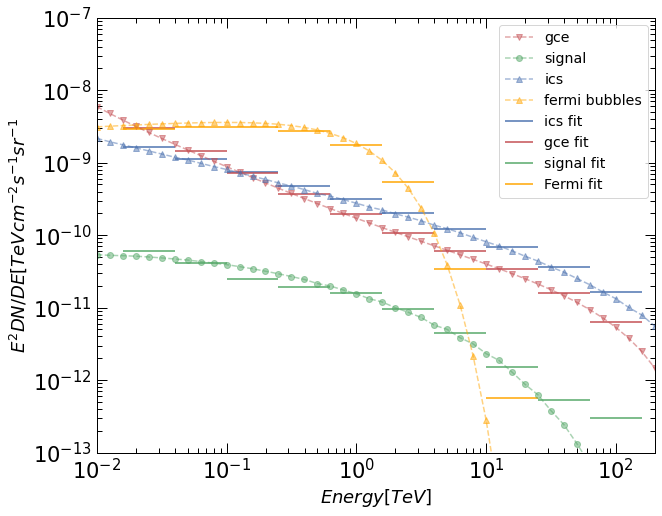

 all strengths at T = 77.57008436174591 


In [22]:
import matplotlib.pyplot as plt

total_T = np.sum(all_T, axis = 0)

sns.reset_orig()


ICS_l = []
GCE_l = []
SI_l = []

ICS_l2 = []
GCE_l2 = []
SI_l2 = []
fermi_l = []

signal_bin = -3

fermi_flux = []
for i in range(47):
  I1 = np.mean(ics_ring_maps[0][i]) * energies[i]**2 * 10**6 
  I2 = np.mean(ics_ring_maps[1][i]) * energies[i]**2 * 10**6
  I3 = np.mean(ics_ring_maps[2][i]) * energies[i]**2 * 10**6
  I4 = np.mean(ics_ring_maps[3][i]) * energies[i]**2 * 10**6

  G1 = np.mean(GCE_ring_maps[0][i]) * energies[i]**2 * 10**6
  G2 = np.mean(GCE_ring_maps[1][i]) * energies[i]**2 * 10**6
  G3 = np.mean(GCE_ring_maps[2][i]) * energies[i]**2 * 10**6
  G4 = np.mean(GCE_ring_maps[3][i]) * energies[i]**2 * 10**6

  S1 = np.mean((signals[injection_spectra][i])) * energies[i]**2 * 10**6
  
  fermi_flux.append(np.mean(fermi_binned_min[i]) * energies[i]**2)

  ICS = I1+I2+I3+I4
  GCE = G1+G2+G3+G4
  
  SI_l.append(S1)
  ICS_l.append(ICS)
  GCE_l.append(GCE)


for energy_bin in range(11):
  j = 2+energy_bin*4

  fermi_li = (np.mean(fermi_binned_min[j]) * energies[j]**2 + np.mean(fermi_binned_min[j+1]) * energies[j+1]**2+ np.mean(fermi_binned_min[j+2])* energies[j+2]**2+ np.mean(fermi_binned_min[j+3])* energies[j+3]**2) / 4 * all_f[energy_bin][signal_bin][2]
  I12 = (np.mean(ics_ring_maps[0][j]) * energies[j]**2 + np.mean(ics_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[0][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0]
  I22 = (np.mean(ics_ring_maps[1][j]) * energies[j]**2 + np.mean(ics_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[1][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0] 
  I32 = (np.mean(ics_ring_maps[2][j]) * energies[j]**2 + np.mean(ics_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[2][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0] 
  I42 = (np.mean(ics_ring_maps[3][j]) * energies[j]**2 + np.mean(ics_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[3][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0]

  G12 = (np.mean(GCE_ring_maps[0][j]) * energies[j]**2 + np.mean(GCE_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[0][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][1]
  G22 = (np.mean(GCE_ring_maps[1][j]) * energies[j]**2 + np.mean(GCE_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[1][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][1]
  G32 = (np.mean(GCE_ring_maps[2][j]) * energies[j]**2 + np.mean(GCE_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[2][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][1]
  G42 = (np.mean(GCE_ring_maps[3][j]) * energies[j]**2 + np.mean(GCE_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[3][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][1]





  fermi_l.append(fermi_li)
  S1 = (np.mean(signals[injection_spectra][j]) * energies[j]**2 + np.mean(signals[injection_spectra][j+1]) * energies[j+1]**2 + np.mean(signals[injection_spectra][j+2]) * energies[j+2]**2 + np.mean(signals[injection_spectra][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][3]



  ICS2 = I12+I22+I32+I42
  GCE2 = G12+G22+G32+G42

  SI_l2.append(S1)
  ICS_l2.append(ICS2)
  GCE_l2.append(GCE2)


import matplotlib as mpl
mpl.rcParams['font.size'] = 17.0
#mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 18.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.figsize'] = (7, 5)
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1


xmin_ics = new_energies[0:-1]
xmax_ics = new_energies[1:]

fig = plt.figure(figsize=[10, 8])
ax = plt.subplot()

ax.plot(energies, GCE_l,  linestyle='--', marker='v', color='r', label = 'gce', alpha= 0.5)
ax.plot(energies, signal_strengts[signal_bin] * np.array(SI_l),  linestyle='--', marker='o', color='g', label = 'signal',  alpha= 0.5)
ax.plot(energies, ICS_l,  linestyle='--', marker='^', color='b', label = 'ics',  alpha= 0.5)
ax.plot(energies, fermi_flux,  linestyle='--', marker='^', color='orange', label = 'fermi bubbles',  alpha= 0.5)



ax.hlines(ICS_l2[:-1], xmin= xmin_ics, xmax=xmax_ics, label= 'ics fit', color = 'b')
ax.hlines(GCE_l2[:-1], xmin= xmin_ics, xmax=xmax_ics, label= 'gce fit', color = 'r')
ax.hlines(SI_l2[:-1], xmin= xmin_ics, xmax=xmax_ics, label= 'signal fit', color = 'g')
ax.hlines(fermi_l[:-1], xmin= xmin_ics, xmax=xmax_ics, label= 'Fermi fit', color = 'orange')

ax.minorticks_on()
ax.minorticks_on()
ax.tick_params('both', length=10, width=1, which='major',
                direction='in', bottom=True, top=True, left=True, right=True, pad=5, labelsize=21)
ax.tick_params('both', length=5, width=1, which='minor',
                direction='in', bottom=True, top=True, left=True, right=True)


ax.set_ylim(10**-13,10**-7)
ax.set_xlim(0.01,200)
ax.set_ylabel(r'$E^{2} DN/DE [TeV cm^{-2} s^{-1} sr^{-1}$')
ax.set_xlabel(r'$Energy [TeV]$')
plt.legend()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

print (f" all strengths at T = {total_T[signal_bin]} ")



## Long Run

In [0]:
import matplotlib.pyplot as plt

total_T = np.sum(all_T, axis = 0)

sns.reset_orig()


ICS_l = []
GCE_l = []
SI_l = []

ICS_l2 = []
GCE_l2 = []
SI_l2 = []
fermi_l = []

signal_bin = 4

for i in range(47):
  I1 = ics_ring_maps[0][i][8][12] * energies[i]**2 * 10**6 
  I2 = ics_ring_maps[1][i][8][12] * energies[i]**2 * 10**6
  I3 = ics_ring_maps[2][i][8][12] * energies[i]**2 * 10**6
  I4 = ics_ring_maps[3][i][8][12] * energies[i]**2 * 10**6

  G1 = GCE_ring_maps[0][i][8][12] * energies[i]**2 * 10**6
  G2 = GCE_ring_maps[1][i][8][12] * energies[i]**2 * 10**6
  G3 = GCE_ring_maps[2][i][8][12] * energies[i]**2 * 10**6
  G4 = GCE_ring_maps[3][i][8][12] * energies[i]**2 * 10**6

  S1 = signals[injection_spectra][i][8][12] * energies[i]**2 * 10**6
  
  ICS = I1+I2+I3+I4
  GCE = G1+G2+G3+G4
  
  SI_l.append(S1)
  ICS_l.append(ICS)
  GCE_l.append(GCE)


for energy_bin in range(11):
  j = 2+energy_bin*4

  fermi_li = (np.mean(fermi_binned_min[j]) * energies[j]**2 + np.mean(fermi_binned_min[j+1]) * energies[j+1]**2+ np.mean(fermi_binned_min[j+2])* energies[j+2]**2+ np.mean(fermi_binned_min[j+3])* energies[j+3]**2) / 4 * all_f[energy_bin][signal_bin][8]
  I12 = (np.mean(ics_ring_maps[0][j]) * energies[j]**2 + np.mean(ics_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[0][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0]
  I22 = (np.mean(ics_ring_maps[1][j]) * energies[j]**2 + np.mean(ics_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[1][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][1] 
  I32 = (np.mean(ics_ring_maps[2][j]) * energies[j]**2 + np.mean(ics_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[2][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][2] 
  I42 = (np.mean(ics_ring_maps[3][j]) * energies[j]**2 + np.mean(ics_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[3][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][3]

  G12 = (np.mean(GCE_ring_maps[0][j]) * energies[j]**2 + np.mean(GCE_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[0][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][4]
  G22 = (np.mean(GCE_ring_maps[1][j]) * energies[j]**2 + np.mean(GCE_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[1][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][5]
  G32 = (np.mean(GCE_ring_maps[2][j]) * energies[j]**2 + np.mean(GCE_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[2][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][6]
  G42 = (np.mean(GCE_ring_maps[3][j]) * energies[j]**2 + np.mean(GCE_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[3][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][7]


  fermi_l.append(fermi_li)
  S1 = (signals[injection_spectra][j][8][12] * energies[j]**2 + signals[injection_spectra][j+1][8][12] * energies[j+1]**2 + signals[injection_spectra][j+2][8][12] * energies[j+2]**2 + signals[injection_spectra][j+3][8][12] * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][9]



  ICS2 = I12+I22+I32+I42
  GCE2 = G12+G22+G32+G42

  SI_l2.append(S1)
  ICS_l2.append(ICS2)
  GCE_l2.append(GCE2)


import matplotlib as mpl
mpl.rcParams['font.size'] = 17.0
#mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 18.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.figsize'] = (7, 5)
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1


xmin_ics = new_energies[0:-1]
xmax_ics = new_energies[1:]

fig = plt.figure(figsize=[10, 8])
ax = plt.subplot()

ax.plot(energies, GCE_l,  linestyle='--', marker='v', color='r', label = 'gce', alpha= 0.5)
ax.plot(energies, signal_strengts[signal_bin] * np.array(SI_l),  linestyle='--', marker='o', color='g', label = 'signal',  alpha= 0.5)
ax.plot(energies, ICS_l,  linestyle='--', marker='^', color='b', label = 'ics',  alpha= 0.5)
#ax.plot(energies, fermi_binned_min,  linestyle='--', marker='^', color='y', label = 'fermi bubbles',  alpha= 0.5)



ax.hlines(ICS_l2[:-1], xmin= xmin_ics, xmax=xmax_ics, label= 'ics fit', color = 'b')
ax.hlines(GCE_l2[:-1], xmin= xmin_ics, xmax=xmax_ics, label= 'gce fit', color = 'r')
ax.hlines(SI_l2[:-1], xmin= xmin_ics, xmax=xmax_ics, label= 'signal fit', color = 'g')
ax.hlines(fermi_l[:-1], xmin= xmin_ics, xmax=xmax_ics, label= 'Fermi fit', color = 'y')

ax.minorticks_on()
ax.minorticks_on()
ax.tick_params('both', length=10, width=1, which='major',
                direction='in', bottom=True, top=True, left=True, right=True, pad=5, labelsize=21)
ax.tick_params('both', length=5, width=1, which='minor',
                direction='in', bottom=True, top=True, left=True, right=True)


ax.set_ylim(10**-13,10**-7)
ax.set_xlim(0.01,200)
ax.set_ylabel(r'$E^{2} DN/DE [TeV cm^{-2} s^{-1} sr^{-1}$')
ax.set_xlabel(r'$Energy [TeV]$')
plt.legend()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

print (f" all strengths at T = {total_T[signal_bin]} ")

